In [1]:
%pip install torchaudio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import render
import rooms.dataset
import evaluate
import torch
#import sounddevice as sd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import metrics

In [2]:
torch.set_default_dtype(torch.float32)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device  = "cpu"

In [3]:
D_0 = rooms.dataset.dataLoader("classroomBase")
#D

In [4]:
D_1 = rooms.dataset.dataLoader("classroomAddedPanel")

## Original audio

In [6]:
'''
sample_rate = 48000

sd.play(D_0.music_dls[0][0], sample_rate)

sd.wait()
'''


'\nsample_rate = 48000\n\nsd.play(D_0.music_dls[0][0], sample_rate)\n\nsd.wait()\n'

## Base

In [5]:
print("Source position: ", D_0.speaker_xyz)
print("Listener position: ", D_0.xyzs[0])

Source position:  [3.5838 5.723  1.2294]
Listener position:  [2.4241125 0.581025  0.32     ]


In [4]:
L_0 = render.get_listener(source_xyz=D_0.speaker_xyz, listener_xyz = D_0.xyzs[0], surfaces=D_0.all_surfaces, 
                                                speed_of_sound=D_0.speed_of_sound,
                                                parallel_surface_pairs=D_0.parallel_surface_pairs,
                                                max_order=D_0.max_order, max_axial_order=D_0.max_axial_order )

Considered Paths:	59049
Total Considered Paths, after Axial:	59079
Valid Paths:	850


In [6]:
import torch
print(torch.version.cuda)  # Mostra la versione di CUDA compatibile
print(torch.cuda.is_available())  # Controlla se CUDA è disponibile


12.1
True


In [5]:
R_0 = render.Renderer(n_surfaces=len(D_0.all_surfaces))

In [6]:
pt_file = torch.load('./models/classroomBase/weights.pt', map_location=device)
R_0.energy_vector = nn.Parameter(pt_file['model_state_dict']['energy_vector'])
R_0.source_response = nn.Parameter(pt_file['model_state_dict']['source_response'])
R_0.directivity_sphere = nn.Parameter(pt_file['model_state_dict']['directivity_sphere'])
R_0.decay = nn.Parameter(pt_file['model_state_dict']['decay'])
R_0.RIR_residual = nn.Parameter(pt_file['model_state_dict']['RIR_residual'])
R_0.spline_values = nn.Parameter(pt_file['model_state_dict']['spline_values'])

In [7]:
RIR_0 = R_0.render_RIR(L_0)

In [11]:
RIR_0

tensor([-4.8656e-10,  3.6881e-06,  5.5116e-06,  ...,  6.9838e-06,
         6.3781e-06,  6.7109e-06], device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
torch.cuda.empty_cache()

In [7]:
RIR_by_direction_0 = R_0.render_RIR_by_directions(L_0)

rtange considerato 20 1000
direzione di arrivo tensor(-169.5764, dtype=torch.float64) tensor(8.0750, dtype=torch.float64)
direzioni considerate 0 -90.0
attenuazione tensor(0.0558, dtype=torch.float64)
direzioni considerate 0.0 0.0
attenuazione tensor(0.0654, dtype=torch.float64)
direzioni considerate 90.0 0.0
attenuazione tensor(0.0495, dtype=torch.float64)
direzioni considerate 180.0 0.0
attenuazione tensor(0.7146, dtype=torch.float64)
direzioni considerate 270.0 0.0
attenuazione tensor(0.0287, dtype=torch.float64)
direzioni considerate 0 90.0
attenuazione tensor(0.0107, dtype=torch.float64)
rtange considerato 1000 5000
direzione di arrivo tensor(-169.5764, dtype=torch.float64) tensor(8.0750, dtype=torch.float64)
direzioni considerate 0 -90.0
attenuazione tensor(0.0558, dtype=torch.float64)
direzioni considerate 0.0 -30.0
attenuazione tensor(0.0348, dtype=torch.float64)
direzioni considerate 60.0 -30.0
attenuazione tensor(0.0361, dtype=torch.float64)
direzioni considerate 120.0 -30.0


In [8]:
len(RIR_by_direction_0[0]['responses'])

6

In [10]:
RIR_by_direction_0[1]

{'frequency_range': (1000, 5000),
 'responses': [{'direction': [0, -90.0],
   'response': tensor([-5.3787e-07,  3.3781e-03,  8.2417e-03,  ...,  7.8734e-03,
            5.2640e-03,  1.7655e-03], device='cuda:0', grad_fn=<AddBackward0>)},
  {'direction': [0.0, -30.0],
   'response': tensor([-6.7438e-07,  3.3783e-03,  8.2392e-03,  ...,  7.8734e-03,
            5.2640e-03,  1.7655e-03], device='cuda:0', grad_fn=<AddBackward0>)},
  {'direction': [60.0, -30.0],
   'response': tensor([-5.3346e-07,  3.3763e-03,  8.2428e-03,  ...,  7.8734e-03,
            5.2640e-03,  1.7655e-03], device='cuda:0', grad_fn=<AddBackward0>)},
  {'direction': [120.0, -30.0],
   'response': tensor([-4.5043e-06,  3.3746e-03,  8.2403e-03,  ...,  7.8734e-03,
            5.2640e-03,  1.7655e-03], device='cuda:0', grad_fn=<AddBackward0>)},
  {'direction': [180.0, -30.0],
   'response': tensor([-5.9184e-06,  3.3732e-03,  8.2481e-03,  ...,  7.8734e-03,
            5.2640e-03,  1.7655e-03], device='cuda:0', grad_fn=<AddBack

In [13]:
angular_sensitivities_em64=[{'frequency_range': (20, 1000), 'angle': 90}, {'frequency_range': (1000, 5000), 'angle': 60}, {'frequency_range': (5000, 20000), 'angle': 45}]

In [14]:
loss_with_zeros = metrics.training_loss_considering_directionality(render.initialize_directional_list(angular_sensitivities_em64, 96000, "cuda:0"), RIR_by_direction_0)
loss_with_zeros

/home/gzanin/.local/lib/python3.11/site-packages/torch/functional.py:665: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:873.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


tensor(1277.0970, device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
loss_with_itself = metrics.training_loss_considering_directionality(RIR_by_direction_0, RIR_by_direction_0)
loss_with_itself

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [20]:
print(RIR_0.unsqueeze(0).shape)
print(D_0.music_dls[0:1,...].shape)

torch.Size([1, 96000])
(1, 1, 624000)


In [18]:
music_0 = evaluate.render_music(RIR_0.unsqueeze(0), D_0.music_dls[0:1,...], device='cpu')[0][0]

/home/gzanin/Desktop/hearinganythinganywhere/evaluate.py:48: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  music_sources = torch.Tensor(music_sources)


In [22]:
print(music_0.shape)

(480000,)


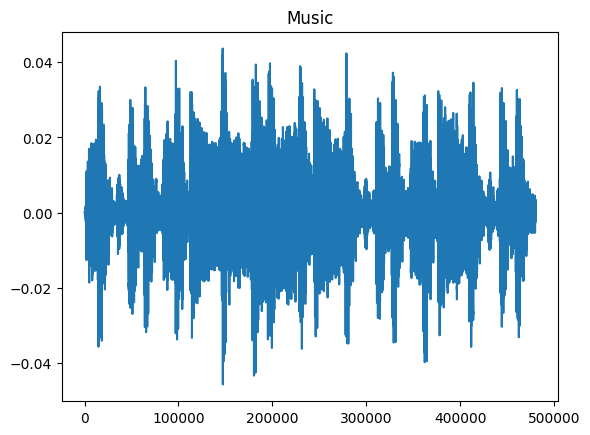

In [23]:
plt.plot(music_0)
plt.title('Music')
plt.show()

In [ ]:

'''
sample_rate = 48000

sd.play(music_0, sample_rate)

sd.wait()
'''


## added panel

In [24]:
print("Source position: ", D_1.speaker_xyz)
print("Listener position: ", D_1.xyzs[0])

Source position:  [3.5838 5.723  1.2294]
Listener position:  [2.4241125 0.581025  0.32     ]


In [20]:
L_1 = render.get_listener(source_xyz=D_1.speaker_xyz, listener_xyz = D_1.xyzs[0], surfaces=D_1.all_surfaces, 
                                                speed_of_sound=D_1.speed_of_sound,
                                                parallel_surface_pairs=D_1.parallel_surface_pairs,
                                                max_order=D_1.max_order, max_axial_order=D_1.max_axial_order )

Considered Paths:	100000
Total Considered Paths, after Axial:	100050
Valid Paths:	1146


In [22]:
R_1 = render.Renderer(n_surfaces=len(D_1.all_surfaces))

In [23]:
modified_energy_vector = torch.tensor([[[-0.5305, -0.4278, -0.2579, -0.3598, -1.6096, -0.7284, -1.8826,
          -1.6226, -1.5753, -1.9941],
         [ 0.5305,  0.4278,  0.2579,  0.3598,  1.6096,  0.7284,  1.8826,
           1.6226,  1.5753,  1.9941]],

        [[-2.4384,  0.8858, -0.2965, -1.5742, -0.2930, -1.9829, -1.7962,
          -1.9131, -0.0154,  0.2472],
         [ 2.4384, -0.8858,  0.2965,  1.5742,  0.2930,  1.9829,  1.7962,
           1.9131,  0.0154, -0.2472]],

        [[-0.9421, -0.6755, -3.6006, -0.7103, -0.8803, -1.3149, -2.2866,
          -2.6399, -2.8685, -2.1082],
         [ 0.9421,  0.6755,  3.6006,  0.7103,  0.8803,  1.3149,  2.2866,
           2.6399,  2.8685,  2.1082]],

        [[-4.0914, -2.7232, -0.8506, -2.3887, -3.6858, -1.3391, -2.6380,
          -1.8897, -2.1227, -3.5193],
         [ 4.0914,  2.7232,  0.8506,  2.3887,  3.6858,  1.3391,  2.6380,
           1.8897,  2.1227,  3.5193]],

        [[-1.1539, -0.4459, -0.3624, -0.7596, -0.7480, -1.5066, -0.9996,
          -2.1747, -0.6960, -2.0290],
         [ 1.1539,  0.4459,  0.3624,  0.7596,  0.7480,  1.5066,  0.9996,
           2.1747,  0.6960,  2.0290]],

        [[-1.7243, -1.1099, -0.0423, -1.1507, -1.2209, -0.4600, -2.0697,
          -2.2589, -2.4818, -1.5450],
         [ 1.7243,  1.1099,  0.0423,  1.1507,  1.2209,  0.4600,  2.0697,
           2.2589,  2.4818,  1.5450]],

        [[-7.8657, -7.9064, -4.2665, -2.9527, -0.6743, -0.7566,  1.5479,
          -1.3406, -2.4598, -2.1531],
         [ 7.8657,  7.9064,  4.2665,  2.9527,  0.6743,  0.7566, -1.5479,
           1.3406,  2.4598,  2.1531]],

        [[-4.5917, -5.2178, -4.6895, -3.5287, -3.0246,  0.2444, -1.6953,
          -1.4810, -1.9807, -1.9190],
         [ 4.5917,  5.2178,  4.6895,  3.5287,  3.0246, -0.2444,  1.6953,
           1.4810,  1.9807,  1.9190]],

        [[-6.7398, -2.8415, -3.7433, -0.8007, -2.0138, -1.9061, -2.0395,
          -2.8121, -3.1212, -2.7330],
         [ 6.7398,  2.8415,  3.7433,  0.8007,  2.0138,  1.9061,  2.0395,
          2.8121,  3.1212,  2.7330]],
           
        [[-6.7398, -2.8415, -3.7433, -0.8007, -2.0138, -1.9061, -2.0395,
          -2.8121, -3.1212, -2.7330],
         [ 6.7398,  2.8415,  3.7433,  0.8007,  2.0138,  1.9061,  2.0395,
          2.8121,  3.1212,  2.7330]]])

In [24]:
pt_file = torch.load('./models/classroomBase/weights.pt', map_location=device)
R_1.energy_vector = nn.Parameter(modified_energy_vector)
R_1.source_response = nn.Parameter(pt_file['model_state_dict']['source_response'])
R_1.directivity_sphere = nn.Parameter(pt_file['model_state_dict']['directivity_sphere'])
R_1.decay = nn.Parameter(pt_file['model_state_dict']['decay'])
R_1.RIR_residual = nn.Parameter(pt_file['model_state_dict']['RIR_residual'])
R_1.spline_values = nn.Parameter(pt_file['model_state_dict']['spline_values'])

In [25]:
torch.cuda.empty_cache()

In [26]:
RIR_1 = R_1.render_RIR(L_1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 898.00 MiB. GPU 

In [ ]:
print(RIR_1.unsqueeze(0).shape)
print(D_1.music_dls[0:1,...].shape)

In [ ]:
music_1 = evaluate.render_music(RIR_1.unsqueeze(0), D_1.music_dls[0:1,...], device='cpu')[0][0]

In [ ]:
plt.plot(music_1)
plt.title('Music')
plt.show()

In [ ]:
'''
sample_rate = 48000

sd.play(music_1, sample_rate)

sd.wait()
'''

In [2]:
import numpy as np

# Specifica il percorso del file .npy
file_path = 'precomputed/classroomBase/ends/0.npy'

# Carica il file .npy
data = np.load(file_path)

# Stampa il contenuto del file
for line in data:
    print(line)


[-1.1596875 -5.141975  -0.9094   ]
[-0.10688527  0.581025   -0.08381695]
[-0.89219183 -7.343775   -0.69963611]
[-0.23951207 -1.06198012  0.32      ]
[-0.71378073 -3.16485492 -2.4232    ]
[ 2.4241125  -2.07471828 -0.36693076]
[-4.7005875  -2.93275982 -0.51868237]
[-0.40570963 -7.343775   -0.31814807]
[-0.06292781  0.581025   -0.04934653]
[-0.23951207 -1.9714625   0.32      ]
[-0.71378073 -5.87524443 -2.4232    ]
[ 2.4241125  -3.8515121  -0.36693076]
[-4.7005875  -5.44438253 -0.51868237]
[-0.10688527  0.581025    0.14280402]
[-0.43937502 -1.94815876 -2.4232    ]
[-0.10688527  0.581025   -0.36286268]
[-0.08107931 -0.35950011  0.32      ]
[ 2.4241125  -2.07471828 -1.58852695]
[-4.7005875  -2.93275982 -2.24549427]
[ 0.55373311  0.581025   -0.08381695]
[ 1.24082354 -1.06198012  0.32      ]
[-4.7005875  -1.56857461 -0.27741515]
[-0.7595957   0.581025   -0.08381695]
[-1.70212728 -1.06198012  0.32      ]
[ 2.4241125  -0.9522536  -0.16841378]
[-0.57445361 -2.51997998 -2.4232    ]
[-0.40570963 -7